# Домашнее задание №4

Это домашнее задание можно выполнять целиком в этом ноутбуке, либо алгоритмы написать в отдельном файле и импортировать сюда, для использования. В папке data лежат два файла islands.fasta и nonIslands.fasta. В них хранятся прочтения из CpG островков и из обычных участков генома соответственно, этими данными нужно будет воспользоваться в первом задании.

In [18]:
# !pip install Bio
from Bio import SeqIO
import numpy as np
import random
from math import log
import matplotlib.pyplot as plt

In [10]:
data = [[], []]
data_i = list(SeqIO.parse('islands.fasta', 'fasta'))
data[0] = list(data_i[0].seq)

data_i = list(SeqIO.parse('nonIslands.fasta', 'fasta'))
data[1] = list(data_i[0].seq)

## Задача №1 (1)
Определите частоты генерации для каждого из нуклеотидов внутри CpG островков и вне их. Посчитайте также частоты для всех упорядоченных пар нуклеотидов и сравните частоту пары CG внутри островков и снаружи. Сделайте вывод. 

In [11]:
single_frequency = [{}, {}]
labels = ['CpG-island', 'not CpG-island']
for label, data_i, single in zip(labels, data, single_frequency):
    print(f'\nfrequency for {label}:')
    nucleotides, frequency = np.unique(data_i, return_counts=True)
    for n, fr in zip(nucleotides, frequency):
        single[n] = fr / len(data_i)
        print(f'\t{n} : {fr / len(data_i):.4f}')


frequency for CpG-island:
	A : 0.1945
	C : 0.2700
	G : 0.3190
	T : 0.2165

frequency for not CpG-island:
	A : 0.2893
	C : 0.1961
	G : 0.1984
	T : 0.3161


In [12]:
paired_frequency = [ {nuc_1: {nuc_2: 0 for nuc_2 in nucleotides} for nuc_1 in nucleotides},  
                     {nuc_1: {nuc_2: 0 for nuc_2 in nucleotides} for nuc_1 in nucleotides} ]
for label, p, data_i in zip(labels, paired_frequency, data):
    print(f'\npaired frequency for {label}\n')
    for i in range(1, len(data_i)):
        p[data_i[i-1]][data_i[i]] += 1
    print(f'\t{nucleotides[0]}\t{nucleotides[1]}\t{nucleotides[2]}\t{nucleotides[3]}')
    for nuc_1 in nucleotides:
        all_pair = sum(p[nuc_1][nuc_i] for nuc_i in nucleotides)
        for nuc_2 in nucleotides:
            p[nuc_1][nuc_2] /= all_pair
        print(f'{nuc_1}\t{p[nuc_1][nucleotides[0]] :.4f}\t{p[nuc_1][nucleotides[1]] :.4f}\t'
              f'{p[nuc_1][nucleotides[2]] :.4f}\t{p[nuc_1][nucleotides[3]] :.4f}')


paired frequency for CpG-island

	A	C	G	T
A	0.2237	0.2057	0.3959	0.1748
C	0.2093	0.3130	0.2444	0.2333
G	0.2166	0.2826	0.3234	0.1774
T	0.1178	0.2540	0.3372	0.2910

paired frequency for not CpG-island

	A	C	G	T
A	0.3107	0.1629	0.2426	0.2838
C	0.3476	0.2550	0.0269	0.3704
G	0.3035	0.1725	0.2525	0.2715
T	0.2246	0.2049	0.2305	0.3400


## Задача №2 (2)
Напишите марковскую модель, которая имеет открытые состояния {A, T, G, C}, и скрытые состояния {+, -}. Когда модель в состоянии **+**, то вероятность генерации некоторого символа нуклеотида соответствует его частоте внутри CpG островков, вычисленому в первом задании, если состояние **-**, то частоте вне островков. Вероятность остаться внутри островка 0.95, а перейти в обычный геном 0.05. Для остальной части генома соответствующие вероятности 0.995 и 0.005. Саму модель можно реализовать в виде итератора, определив метод next, который возвращает пару - состояние и нуклеотид, который в этом состоянии произведен.    
Воспользуйтесь данной моделью для того чтобы сгенерировать набор из 20 последовательностей длинной от 1 000 до 100 000, причем к каждой последовательности должна прилагаться последовательность состояний.

In [13]:
class CpG:
    def __init__(self, open_state: list=['A', 'C', 'G', 'T'], close_state: list=['+', '-'],
                 island: list=[0.95, 0.05], non_island: list=[0.995, 0.005], count_sequence: int=20):
        # x - open state, pi - close state
        self.x, self.pi = open_state, close_state
        self.island, self.gen = island, non_island[::-1]
        self.p_isl, self.p_gen = None, None
        self.single_isl, self.single_gen = None, None
        self.sequence_x = [[] for _ in range(count_sequence)]
        self.sequence_pi = [[] for _ in range(count_sequence)]

    def probability(self, probability_isl: dict, probability_genom: dict):
        self.p_isl, self.p_gen = probability_isl, probability_genom
    
    def single_probability(self, probability_isl: dict, probability_genom: dict):
        self.single_isl, self.single_gen = probability_isl, probability_genom

    def __next__(self, i, x_i, pi_i):
        if pi_i == self.pi[0]:
            pi_i = random.choices(
                population=self.pi,
                weights=self.island
            )
            weights = [self.p_isl[x_i][i] for i in self.x]
            x_i = random.choices(
                population=self.x,
                weights=weights
            )
            self.sequence_x[i].append(*x_i)
            self.sequence_pi[i].append(*pi_i)
        else:
            pi_i = random.choices(
                population=self.pi,
                weights=self.gen
            )
            weights = [self.p_isl[x_i][i] for i in self.x]
            x_i = random.choices(
                population=self.x,
                weights=weights
            )
            self.sequence_x[i].append(*x_i)
            self.sequence_pi[i].append(*pi_i)

        return [x_i, pi_i]

In [14]:
island, non_island = [0.95, 0.05], [0.995, 0.005] # [in, out]
x, pi = nucleotides, ['+', '-']
count_sequence, len_sequence = 20, 10000
gen = CpG(x, pi, island, non_island)
gen.probability(*paired_frequency)
gen.single_probability(*single_frequency)


for i in range(count_sequence):
    new = [*random.choices(x), *random.choices(pi)]
    gen.sequence_x[i] = [new[0]]
    gen.sequence_pi[i] = [new[1]]
    for _ in range(len_sequence):
        ans = gen.__next__(i, *new)
        new = [*ans[0], *ans[1]]

    print(i + 1, '\t', *gen.sequence_x[i], sep='')
    print('\t', *gen.sequence_pi[i], sep='')

1	TATAAACTCGCGAGCCGGGCTCGACTAGCCCCTGGTCCGTTGGTCGCCCTGGGTCCCAGACTTTTGCGAACTGCACGCTTCCCCAACCCCGACCTCGGGATCGTAGCCCGGGGACTGTCAGAACTTGAGGCGGGAAAGGTGCGGACCTTGAGGGAGCTGGGGTGAAGGCCGCCCTGGAAGGGCTTTTCCGGGTGCTGCCAAGGGGCAAGCTCCGCCCACCATGGTGCAAATTCCTCTGTCCCAGCCTGGGCTTGTGCAGCTCGGTCCCGGGTCGCCTCCCACTTTGGGCTGCTGGGAGCAGAGTTCACCCTCTGCGGCAGGCGGCAGTACTGCGCTCGTGCCAGACCCCATTCCCTGCTGACGGATTTCCCCGTTCGTTCATGACCGGAGTTGCTGCTAGGCTACGTGGCAGGAAGATCCGCCGACTTTTGCTGGGTGGCGCTTTCGTCAGGAAGATTCGAAAGGGATTCAAACCCTGCAGGCCATGAGGCCGCGCAATGAGACCAGCCGCATGGGAATGCCAGGCCTGGCTTCAGGGGTTCGCACGTCCAAAAATCTTTTGCTCAGTGGTTTAAGTTATTGGCACAACGAGGGCTAAGCAAGCCGGGGCGGCCAGAATTTGGACTAACTTGGCGATAAAGCCAAGCTTACGCTTTGAGATTGAAGGCCTCCCTCATGAAACTGTTTTCACCCCTTCATGTTGAGCCAGGCAGTTCATAGTGTGGGGAGTGATTTTGGGCCCAATGCTGGCTGTTTCGCCACTGCGGCCCGGCGCGTACTCAGATTCCCAGGTTCAGCTGCAGGGACAAAGCATCGCGAAGCCTGACCCACCATTTGTCAAGATCCCCGGGTGCCTCGACATCCTGACGTTAATCTATTGGAGCACAGGGTGCCATTGCTAGAGCATGCGGGCGAGGCTACCGGCCAATAGCAGCCAAGTCCCCGGCTCAAGAAGGGCACCGATCTGGTTTATCTGACTGACCCGCTGTTTTGGCACG

## Задача №3 (4)
Напишите алгоритм Витерби для восстановления последовательности скрытых состояний марковской модели из второго задания. Воспользуйтесь им, воссстановив состояния тех последовательностей, которые вы получили во втором задании и посчитайте TP, TN, FP, FN по количеству правильно или ошибочно предсказанных позиций из CpG островков. 

In [16]:
def _one_sequence(count, mistake, seq, corr_pi):
    a = gen.gen, gen.island
    n = len(seq)
    v = np.zeros((2, 2))
    v[1][0] = -1e5
    parent = [['' for _ in range(n)] for _ in range(2)]
    parent[0][0], parent[1][0] = '-', '-'

    for i in range(1, n):
        gg, ig = log(a[0][1]) + v[0][0], log(a[1][1]) + v[1][0]
        v[0][1] = log(gen.single_gen[seq[i]]) + gg if gg > ig else log(gen.single_gen[seq[i]]) + ig

        gi, ii = log(a[0][0]) + v[0][0], log(a[1][0]) + v[1][0]
        v[1][1] = log(gen.single_isl[seq[i]]) + gi if gi > ii else log(gen.single_isl[seq[i]]) + ii

        if parent[0][i-1] == '-':
            parent[0][i] = '+' if gi > ii else '-'
        else:
            parent[0][i] = '-' if gg > ig else '+'

        if parent[1][i-1] == '-':
            parent[1][i] = '+' if gi > ii else '-'
        else:
            parent[1][i] = '-' if gg > ig else '+'

        v[0][0], v[1][0] = v[0][1], v[1][1]

    if v[0][1] > v[1][1]:
        ans = parent[0]
        print(count, ' : \t', *ans, sep='')
    else:
        ans = parent[1]
        print(count, ' : \t', *ans, sep='')
    print('\t', *corr_pi, '\n', sep='')

    for i in range(n):
        if ans[i] == '+' and corr_pi[i] == '+':
            mistake[0] += 1
        elif ans[i] == '+' and corr_pi[i] == '-':
            mistake[2] += 1
        elif ans[i] == '-' and corr_pi[i] == '+':
            mistake[3] += 1
        else:
            mistake[1] += 1
    
    return mistake

count = 1
# TP, TN, FP, FN = mistake
mistake = [0, 0, 0, 0]
for seq_i, corr_i in zip(gen.sequence_x, gen.sequence_pi):
    mistake = _one_sequence(count, mistake, seq_i, corr_i)
    count += 1

mistake = [mistake[i] / (count_sequence * len_sequence) for i in range(len(mistake))]
print(f'Точность предсказания {sum(mistake[:2]) * 100:.2f} %')
print(f'TP = {mistake[0]}\tTN = {mistake[1]}\tFP = {mistake[2]}\tFN = {mistake[3]}')

1 : 	-+-+-+--+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-+--+-+-+--------+--+-+--------------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Задача №4 (4)
Напишите алгоритм вперед назад для модели из второго задания. Пользуясь этим алгоритмом найдите вероятности того, что модель находилась в состоянии **+** для каждой позиции строк из второго задания. Устанавливая различные пороговые значения, определите позиции соответствующие CpG островкам и посчитайте TP. Постройте график зависимости TP от выбранного порогового значения. Есть ли пороговые значения при которых TP больше чем в задании №3?

In [25]:
count_sequence, len_sequence = 2000, 50
gen = CpG(x, pi, island, non_island, count_sequence)
gen.probability(*paired_frequency)
gen.single_probability(*single_frequency)
a = gen.gen, gen.island

for i in range(count_sequence):
    new = [*random.choices(x), *random.choices(pi)]
    gen.sequence_x[i] = [new[0]]
    gen.sequence_pi[i] = [new[1]]
    for _ in range(len_sequence):
        ans = gen.__next__(i, *new)
        new = [*ans[0], *ans[1]]

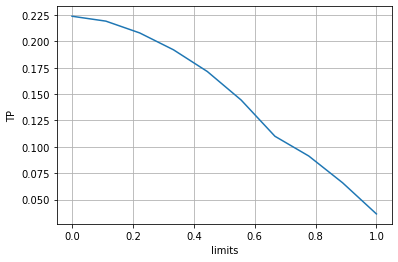


The best TP = 22.39 %


In [27]:
def _one_sequence_f_b(true_positive, seq, corr_pi, limit):
    n = len(seq)
    f, b = np.zeros((2, n + 1)), np.zeros((2, n + 1))
    f[0][0], f[1][0] = 1, 0
    b[0][-1], b[1][-1] = a[0][1], a[1][1]

    for i, j in zip(range(n), range(n - 1, -1, -1)):
        f[0][i + 1] = gen.single_gen[seq[i]] * (f[0][i] * a[0][1] + f[1][i] * a[1][1])
        f[1][i + 1] = gen.single_isl[seq[i]] * (f[0][i] * a[0][0] + f[1][i] * a[1][0])
        b[0][j] = a[0][1] * gen.single_gen[seq[j]] * b[0][j + 1] + a[0][0] * gen.single_isl[seq[j]] * b[1][j + 1]
        b[1][j] = a[1][1] * gen.single_gen[seq[j]] * b[0][j + 1] + a[1][0] * gen.single_isl[seq[j]] * b[1][j + 1]
    p = a[0][1] * gen.single_gen[seq[0]] * b[0][0] + a[0][0] * gen.single_isl[seq[0]] * b[1][0]

    result = f[:, 1:] * b[:, :-1] / p
    ans = ['' for _ in range(n)]
    ans[0] = '-'

    for i in range(1, n):
        ans[i] = '-' if result[0][i] < limit else '+'
        if ans[i] == '+' and corr_pi[i] == '+':
            true_positive += 1

    return true_positive

limit = np.linspace(0, 1, 10)
tp = np.zeros(limit.shape)
best_tp, best_lim = 0, 0
for lim_i, i in zip(limit, range(len(limit))):
    count = 1
    true_positive = 0
    for seq_i, corr_i in zip(gen.sequence_x, gen.sequence_pi):
        true_positive = _one_sequence_f_b(true_positive, seq_i, corr_i, lim_i)
        count += 1

    true_positive /= (count_sequence * len_sequence)
    if true_positive > best_tp:
        best_tp, best_lim = true_positive, lim_i
    tp[i] = true_positive

plt.plot(limit, tp)
plt.xlabel('limits')
plt.ylabel('TP')
plt.grid()
plt.show()
print(f'\nThe best TP = {best_tp * 100:.2f} %')